In [ ]:
######### Web Scraper #########
 
#import all necessary libraries
import urllib.request
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import time
from fake_useragent import UserAgent
import random
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from datetime import date
import os


#all brands - warning time and data intensive to loop through all in one attempt
brands = [11, 62, 4, 45, 72, 65, 26, 16, 52, 51, 49, 73, 26, 16, 52, 51, 49, 73]

#select brands to be scraped (11 = BMW)
run = [11]

data = [] #create a data frame to store the data
delay = 2 #set default time delay before requesting next page

# Set up user agent and browser as well as chrome options (to mimic human behaviour)
user_agent = UserAgent()
options = webdriver.ChromeOptions()
options.add_argument(f'user-agent={user_agent.random}')
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
browser = webdriver.Chrome(options=options)

#initialize first for-loop (selected brands)
for brand in run:

    #initialize second for-loop to loop through all pages of a brand
    for page in range(1, 121):
        
        # Define the URL for the current page of listings
        url = f'https://www.12gebrauchtwagen.de/suchen?page={page}&s%5Bmk%5D={brand}&s%5Bprovider_id%5D%5B%5D=4&s%5Bprovider_id%5D%5B%5D=68&s%5Bprovider_id%5D%5B%5D=26&s%5Bprovider_id%5D%5B%5D=16&s%5Bprovider_id%5D%5B%5D=34&s%5Bprovider_id%5D%5B%5D=35&s%5Bprovider_id%5D%5B%5D=28&s%5Bprovider_id%5D%5B%5D=27'
                
        # Make the request and handle errors
        try:
            browser.get(url)
            html = browser.page_source
            #we use beautifulsoup library for scraping
            soup = BeautifulSoup(html, 'html.parser')
        except requests.exceptions.RequestException as e:
            print(f'Error: {e}')
            print(f'Retrying in {delay} seconds...')
            time.sleep(delay) #if an error occurs let the scraper go to sleep
            continue  # go to the next iteration of the loop

        # Find all the listings on the page (listings are divided in premium and regular listings on the webpage)
        premium_listings = soup.find_all('div', class_='row car-ad result-slot box-shadow new-car-ad premium-result')
        regular_listings = soup.find_all('div', class_='row car-ad result-slot box-shadow new-car-ad regular-result')
        all_listings = premium_listings + regular_listings
        
        # Loop through each listing and extract the name, price, mileage, registration date, power, info and dealer 
        for listing in all_listings:
            
            name = listing.find('h3', class_='ad-display-name truncate').text.strip()
            price = listing.find('span', class_='ad-price').text.strip()
            milage = listing.find('span', class_='ad-mileage').text.strip()
            rd = listing.find('span', class_='ad-registration-date').text.strip()
            power = listing.find('span', class_='ad-power truncate').text.strip()
            info = listing.find('div', class_='small-8 columns float-left').text.strip()
            dealer = listing.find('span', class_='small-ad-extra-info').text.strip()
            
            data.append({'Brand': brand, 'Name': name, 'Price': price, 'Power': power, 'Milage': milage,
                        'Registration Date': rd, 'Info': info, 'Dealer': dealer})
        
        # Randomize the delay before making the next request and switch the user agent (to mimic human behaviour)
        time.sleep(delay * (1 + 2 * (1 + random.random())))
        options = webdriver.ChromeOptions()
        options.add_argument(f'user-agent={user_agent.random}')
        options.add_argument('--headless')
        options.add_argument('--disable-gpu')
        options.add_argument('--no-sandbox')
        browser = webdriver.Chrome(options=options)

# Close the browser window
browser.quit()
            
# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

#safe as csv file
df.to_csv('auto.csv', index = False)
print('DataFrame saved to auto.csv')



###Sources: Documentation of imported packages, Youtube Channel: John Watson Rooney, Tech With Tim, Tinkernut

In [ ]:
######### Data Cleaning #########

#open csv file and save it in bmw
bmw = pd.read_csv('auto.csv')

#Data Cleaning in order to be able to work with power mileage and price as integers and provide a better overview
bmw['Registration Date'] = bmw['Registration Date'].str.replace('EZ', '')
bmw['Registration Date'] = pd.to_datetime(bmw['Registration Date'])
bmw['Dealer'] = bmw['Dealer'].str.replace('gefunden auf', '')
bmw['Milage'] = bmw['Milage'].str.replace('km', '')
bmw['Milage'] = bmw['Milage'].str.replace('.', '')
bmw['Power'] = bmw['Power'].str.slice(start=12)
bmw['Power'] = bmw['Power'].str.slice(stop=3)
bmw['Power'] = bmw['Power'].str.replace('P','')
bmw['Price'] = bmw['Price'].str.replace('€', '')
bmw['Price'] = bmw['Price'].str.replace('.', '')
bmw['Info'] = bmw['Info'].str.slice(stop=6)
bmw['Price'] = bmw['Price'].astype(int)
bmw['Power'] = bmw['Power'].astype(int)
bmw['Milage'] = bmw['Milage'].astype(int)


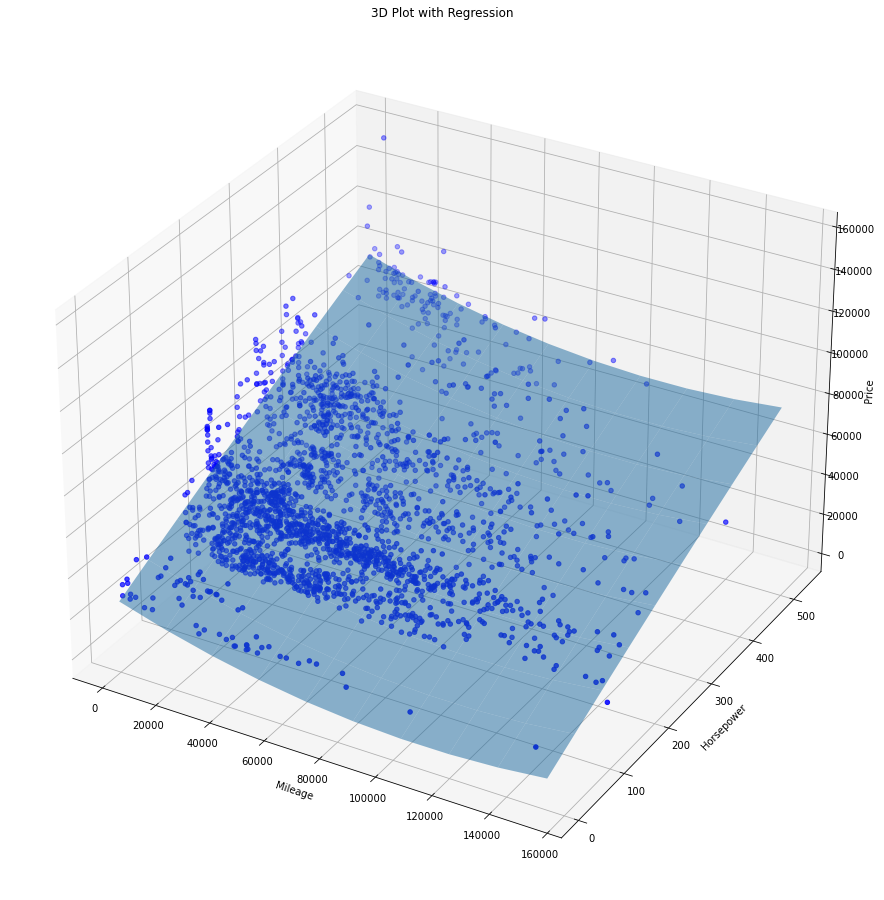

In [22]:
###### Data Analysis #######

#importing all necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

#get necessary data for the regression 
horsepower = bmw['Power']
mileage = bmw['Milage']

#define a custom non linear function for regression(non linear function are able to explain the price better than linear ones)
def non_linear_func(x, a, b, c, d, e):
    mileage, horsepower = x
    return a * mileage ** 2 + b * horsepower ** 2 + c * mileage + d * horsepower + e

# define the threshold for underpriced vehicles
threshold = 0.8

#Calculate z-scores in order to get rid of outliers
mileage_zscores = stats.zscore(mileage)
horsepower_zscores = stats.zscore(horsepower)
zscore_threshold = 3 #set a default zscore threshold value
outlier_indices = (np.abs(mileage_zscores) > zscore_threshold) | (np.abs(horsepower_zscores) > zscore_threshold)
bmw_filtered = bmw[~outlier_indices] #drop the outliers and save in bmw_filtered

#save the filtered data
horsepower = bmw_filtered['Power']
mileage = bmw_filtered['Milage']
price = bmw_filtered['Price']

#create and numpy array with milage and horsepower
X = np.array([mileage, horsepower])
#fit the non linear regression with the curve_fit module from scipy optimize package to explain the price
popt, _ = curve_fit(non_linear_func, X, price)

# Calculate predicted prices (for detecting underpriced vehicles)
predicted_prices = custom_non_linear_func(X, *popt)

# Filter data with higher predicted prices than the non-linear model suggests
higher_predicted_prices_data = bmw_filtered[predicted_prices > price * (1 + threshold)]

# Save the filtered data to a separate variable and file
filtered_data = higher_predicted_prices_data.copy()  # Save to a new variable
filtered_data.to_csv("filtered_data_80.csv", index=False)  # Save to a CSV file

# Initialize the plot and define dimensions
fig = plt.figure(figsize = (20, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mileage, horsepower, price, c='b', marker='o')

# Generate meshgrid for the surface
mileage_range = mileage.max() - mileage.min()
horsepower_range = horsepower.max() - horsepower.min()
mileage_grid, horsepower_grid = np.meshgrid(
    np.linspace(mileage.min(), mileage.max(), num=10),
    np.linspace(horsepower.min(), horsepower.max(), num=10))

# predict the price with the non-linear model for plotting
price_pred = non_linear_func([mileage_grid.flatten(), horsepower_grid.flatten()], *popt)

# Plot the surface
ax.plot_surface(mileage_grid, horsepower_grid, price_pred.reshape(mileage_grid.shape), alpha=0.5)

# Set labels and title
ax.set_xlabel('Mileage')
ax.set_ylabel('Horsepower')
ax.set_zlabel('Price')
plt.title('3-Dimensional Plot with Regression')

# Show the plot
plt.show()

###Sources: Documentation of imported packages, Jupyter Notebooks of Intro to CS course (HSG), ChatGPT for the non-linear regression model